# Variational Amplitude estimation 

This project is to implement multi-qubit variational quantum amplitude estimation (VQAE) pennylane and NVIDIA GPU. This will provide a comprehensive overview of quantum amplitude estimation and unitary operator A before diving into the three different algorithms: classical Monte-Carlo method (CMC), maximum likelihood amplitude estimation (MLAE), and VQAE.

In quantum computing, quantum amplitude estimation is a crucial task for estimating the value of the unknown parameter 'a'. It is typically used to estimate the probability of a specific measurement outcome in a quantum state. The unitary operator A is an operation for n+1 qubits and its effect on a zero state can be written as:

$$
A | 0 \rangle_{n+1}=| \chi_0 \rangle_{n+1}
=\sqrt{a}| \psi_{good}\rangle_{n}| 1 \rangle
+\sqrt{1-a}| \psi_{bad}\rangle_{n}| 0 \rangle,
$$

Here, good state |ψgood⟩n and bad state |ψbad⟩n are orthonormal quantum states of n qubits, each of them corresponds to an ancillary qubit. The parameter 'a' is the corresponding quantum amplitude.

In the era of noisy intermediate-scale quantum (NISQ), researchers are exploring ways to implement quantum algorithms on hardware, and as a result, they are pursuing shallower quantum circuits and more concise quantum operations. To compare the performance of different estimation algorithms, we used total number of same shots. The aim is to achieve higher estimation accuracy with lower quantum query complexity.

The three algorithms that will be reviewed in this project are CMC, MLAE, and VQAE. CMC is a classical algorithm that is used to estimate the quantum amplitude a. It employs random sampling and Monte Carlo methods to estimate the amplitude. MLAE is a quantum algorithm that uses the maximum likelihood estimator to estimate the amplitude. In comparison to CMC, MLAE provides better estimation accuracy with the same quantum query complexity.

Finally, the focus of this hackathon is on VQAE, a quantum algorithm that is developed based on MLAE and requires a shallower quantum circuit than MLAE. We have implemented VQAE and compare its performance with CMC and MLAE. We also studied about the advantages and disadvantages of each algorithm and how to use them to estimate the quantum amplitude accurately.

In MLAE, the depth of quantum circuits grows as $2m+1$, which can make implementation difficult despite eliminating quantum phase estimation. However, recent work [1] has proposed amplitude estimation with the aid of constant-depth quantum circuits that use variational approximation during amplitude amplification.

The key difference between VQAE and MLAE lies in the variational approximation process. In MLAE's quantum amplitude amplification (Step 1), the state $|1\rangle_{n+1}$ is periodically replaced by a variational quantum state. For linear increment sequences in MLAE, a positive integer $k$ is chosen as the variational period, and the variational approximation begins when it reaches $Q^k\ (0<k<M)$. VQAE, on the other hand, employs a variational quantum circuit to approximate the state and provide a good estimate of the quantum amplitude. This allows for a shallower quantum circuit, making VQAE more efficient than MLAE.

In [26]:
![Pesudo](./VQAE-fig-pesudo.png)

/bin/bash: -c: line 1: syntax error near unexpected token `./VQAE-fig-pesudo.png'
/bin/bash: -c: line 1: `[Pesudo](./VQAE-fig-pesudo.png)'


Based on $\{h_m\}$, we can calculate the single likelihood functions $L_m(h_m;\theta_a)$ and continue to follow the process of MLAE. 

From the same process as MLAE, the estimation result can be written as:

$$
\hat{\theta_a}
=\arg{\max_{\theta_a}{\text{ln}[L(\{h_m\};\theta_a)]}}
$$

First, We will start Variatonal Quantum Amlitude estimation same as MLAE Jupyter Notebook.

In [2]:
import pennylane.numpy as np 
from scipy import optimize 
import pennylane as qml 

import matplotlib.pyplot as plt

In [3]:
n_qubits = 6
n = n_qubits - 1
N=2**(n_qubits - 1)
target = n_qubits-1

# Example p and theta_i
p = np.ones(32)/32
theta_i = np.sin(np.arange(32)/6)
assert len(p) == 2**n
assert len(theta_i)==2**n
a = np.sum(p * np.sin(theta_i/2)**2)

def Rotf(n, theta_i):
    for i in range(2**n):
        binary=format(i, 'b').zfill(n)
        qml.ctrl(qml.RY, range(n) , control_values=[int(x) for x in binary])(theta_i[i], wires=n)

# Set A 
def A(p,theta_i,n):
    # prepare state 
    psi = np.sqrt(p)
    overlap = psi[0]
    denominator = np.sqrt(2 + 2 * overlap)
    psi[0] += 1
    psi /= denominator

    dim = len(p)
    qml.QubitUnitary(2 * np.outer(psi, psi) - np.eye(dim), wires=range(n))
    # encode f[x] = sin^2(theta_i[x]/2)
    Rotf(n,theta_i)
    
def reflect(n_qubits, target):
    for i in range( n_qubits):
        qml.PauliX(wires =i)
    qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
    for i in range( n_qubits):
        qml.PauliX(wires =i)
        
def Q(p, theta_i, n, target):
    # reflect respect to |psi_g>|1> 
    qml.PauliZ(wires = target)
    # reflect respect to chi
    qml.adjoint(A)(p,theta_i,n)
    reflect(n+1, target)
    A(p,theta_i,n)
    
def cal_theta(n_grovers, hits, shots):
    # set range 
    m =  10**(-15)
    M = 1 - m
    thetas = [] 
    for i, n_grover in enumerate(n_grovers):

        def log_likelihood(probs):
            theta = np.arcsin(np.sqrt(probs))
            p = np.zeros_like(probs)
            for j in range(i+1):
                phi = (2 * n_grovers[j]+1) * theta
                p +=  2 * hits[j] * np.log(np.abs(np.sin(phi))) \
                    +2*(shots - hits[j])*np.log(np.abs(np.cos(phi)))
            
            return -p
        result = optimize.brute(log_likelihood, [(m, M)])
        p_cand = result[0]
        thetas.append(np.arcsin(np.sqrt(p_cand)))
        p_error = CM_error_bound(n_grovers, i, p_cand, shots)
        M = min(p_cand + 5 * p_error, 1-10**(-15))
        m = max(p_cand - 5 * p_error, 10**(-15))
    return thetas 

def CM_error_bound(n_grovers, M, p, shots):
    #Fisher_info = 0
    Fisher_info = np.sum((2*np.array(n_grovers[:M+1])+1)**2)
    Fisher_info = Fisher_info*shots / (p * (1 - p)) 
    return np.sqrt(1 / Fisher_info)

Now we will make the hardware efficient ansatz U like the figure below.
![Ansatz](./Hardware_efficient.png)

We have tried various ansatz but most of the circuit were not suitable for this system so we have choose this system.

In [18]:
def make_iansatz(n_qubits):
    def inital_ansatz(params):
        
        for i in range(n_qubits):
            qml.RY(params[i],wires=i)
            # qml.RZ(params[i],wires=i)
    return inital_ansatz

def make_ansatz(n_qubits):    
    def ansatz(params):
        for i in range(n_qubits//2):
            qml.CZ(wires=(2*i, 2*i+1))
            # qml.CNOT(wires=(2*i, 2*i+1))
        for i in range(n_qubits):
            qml.RY(params[i],wires=i)
            # qml.RZ(params[i],wires=i)
        for i in range((n_qubits-1)//2):
            qml.CZ(wires=(2*i+1, 2*i+2))
            # qml.CNOT(wires=(2*i+1, 2*i+2))
        for i in range(n_qubits):
            qml.RY(params[i+n],wires=i)
            # qml.RZ(params[i+n],wires=i)
    return ansatz

iansatz=make_iansatz(n_qubits=n_qubits)
ansat=make_ansatz(n_qubits=n_qubits)

Now we are going to set two type of cost function. First one is on this Notebook and second one is on the VQAE2.ipynb
First cost function is made by using 
$$
\langle 0| A U \textit{Q}^\dagger \textit{A}^\dagger | 0 \rangle=1
$$
The second cost funciont is made by using
$$
Fidelity( Q| 0 \rangle, U| 0 \rangle)=1
$$
When ansatz is exactly same with the Q operator.

First one could use NVIDIA GPU("lightning.gpu") in the pennylane.

The second one could not use NVIDIA GPU so the learning system was based on CPU

In [5]:

Vdev = qml.device("lightning.gpu", wires=n_qubits, shots=30)
def vqae(layer, OC,batch, it):
    b_max = np.pi/5
    def A():
        for i in range(n_qubits-1):
            qml.Hadamard(wires = i)

        qml.RY(b_max/N, wires = target )
        for i in range(n_qubits-1):
            qml.CRY(2**(i+1) * b_max / N , wires = [i, target])
    @qml.qnode(Vdev)
    def VC(weights):
        
        A()
        iansatz(weights[:n_qubits])
        for i in range(layer):
            ansat(weights[n_qubits*(2*i+1):n_qubits*(2*i+3)])
        
        qml.adjoint(OC)(n_qubits)
        qml.adjoint(A)()
        
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]
    def loss( weights):
        out=np.zeros(n_qubits)
        out+=np.array(VC( weights))
        # print(out/batch)
        # return (1-np.mean(out/batch))**2
        return np.log(1.0000001-np.mean(out))
    
    opt=qml.AdagradOptimizer(0.2)

    weights = np.random.randn(n_qubits*(2*layer+1), requires_grad=True)
    
    cost_history = []
    for it in range(it):
        weights, cost = opt.step_and_cost(loss, weights)
        print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
        cost_history.append(cost)
        if cost<-5:
            break
    return weights,cost

In [6]:
def Qop(n_qubits):
    b_max = np.pi/5
    def A():
        # superposition 
        for i in range(n_qubits-1):
            qml.Hadamard(wires = i)
        # encode f(x)
        qml.RY(b_max/N, wires = target )
        for i in range(n_qubits-1):
            qml.CRY(2**(i+1) * b_max / N , wires = [i, target])
            
    def reflect():
        for i in range( n_qubits):
            qml.PauliX(wires =i)
        qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
        for i in range( n_qubits):
            qml.PauliX(wires =i)
    def A_inv():
        # inverse of A 
        for i in range(n_qubits-2, -1, -1):
            qml.CRY(-2**(i+1) * b_max / N, wires = [i, target])
        qml.RY(-b_max/N, wires = target )  

        for i in range(n_qubits-1):
            qml.Hadamard(wires = i)
    def Q():
        # reflect respect to |psi_g>|1> 
        qml.PauliZ(wires = target)
        # reflect respect to chi
        A_inv()
        reflect()
        A()
    
    # start circuit 
    
    Q()


# Naive VQAE
We have learned Naive VQAE(learning every Q^k)

In [7]:
layer=3
batch=30
it=100
# weights,cost=vqae(layer, Qop,batch, it )

In [8]:
k=32
weight_list=[]
cost_list=[]
weights,cost=vqae(layer, Qop,batch, it )
weight_list.append(weights)
cost_list.append(cost)
def PQC(weights):
    iansatz(weights[:n_qubits])
    for i in range(layer):
        ansat(weights[n_qubits*(2*i+1):n_qubits*(2*i+3)])

for i in range(k):
    def OQ(n_qubits):
        PQC(weight_list[-1])
        Qop(n_qubits)    
    weights,cost=vqae(layer, OQ,batch, it )
    weight_list.append(weights)
    cost_list.append(cost)

Step   0       Cost_L = -0.2093501
Step   1       Cost_L = -0.4222721
Step   2       Cost_L = -0.3889357
Step   3       Cost_L = -0.6496619
Step   4       Cost_L = -0.4567582
Step   5       Cost_L = -0.7862374
Step   6       Cost_L = -0.9734489
Step   7       Cost_L = -0.9444614
Step   8       Cost_L = -1.0986120
Step   9       Cost_L = -1.0986120
Step  10       Cost_L = -1.3217555
Step  11       Cost_L = -1.3643151
Step  12       Cost_L = -1.7272204
Step  13       Cost_L = -1.5040769
Step  14       Cost_L = -2.5538982
Step  15       Cost_L = -1.0340735
Step  16       Cost_L = -2.4203670
Step  17       Cost_L = -2.1972237
Step  18       Cost_L = -2.7080487
Step  19       Cost_L = -3.1135131
Step  20       Cost_L = -1.6665958
Step  21       Cost_L = -3.4011944
Step  22       Cost_L = -1.8607517
Step  23       Cost_L = -3.4011944
Step  24       Cost_L = -3.1135131
Step  25       Cost_L = -2.8903700
Step  26       Cost_L = -4.4998007
Step  27       Cost_L = -1.3217555
Step  28       Cost_

If we see the cost the ansatz had learned maximum of 10% error.
It seemed suitable for VQAC system.

In [21]:
shots = 1000
# dev = qml.device('default.qubit', wires = n_qubits, shots = shots)
n_qubits = 6
y = np.pi/3
N = 2**(n_qubits-1)
target = n_qubits -1

dev = qml.device('lightning.gpu', wires = n_qubits, shots = shots)
n_grovers = [0,1,2,4,8,16,32]

analytic_result = (y / 2. - np.sin(2 * y) / 4.)/y 
print("Analytical Result:", analytic_result)

ret = []
for n_grover in n_grovers:
    @qml.qnode(device = dev)
    def circuit(n_grover):
        

        # define function 
        
        def A():
            # superposition 
            for i in range(n_qubits-1):
                qml.Hadamard(wires = i)
            # encode f(x)
            qml.RY(y/N, wires = target )
            for i in range(n_qubits-1):
                qml.CRY(2**(i+1) * y/ N , wires = [i, target])

        def reflect():
            for i in range( n_qubits):
                qml.PauliX(wires =i)
            qml.ctrl(qml.PauliZ, range(n_qubits-1), control_values=[1 for _ in range(n_qubits-1)])(wires = target)
            for i in range( n_qubits):
                qml.PauliX(wires =i)
        def A_inv():
            # inverse of A 
            for i in range(n_qubits-2, -1, -1):
                qml.CRY(-2**(i+1) * y / N, wires = [i, target])
            qml.RY(-y/N, wires = target )  

            for i in range(n_qubits-1):
                qml.Hadamard(wires = i)
        def Q():
            # reflect respect to |psi_g>|1> 
            qml.PauliZ(wires = target)
            # reflect respect to chi
            A_inv()
            reflect()
            A()

        # start circuit 
        A()
        for i in range(n_grover): 
            PQC(weight_list[i])
        return qml.sample(wires = target)
    ret.append(circuit(n_grover))
hits = []
for i in ret: 
    hits.append(np.sum(i).item()) # count number of 1s 
print(hits)

Analytical Result: 0.2932516642168279
[310, 944, 740, 494, 248, 511, 580]


Text(0.5, 0, 'depth(# of A)')

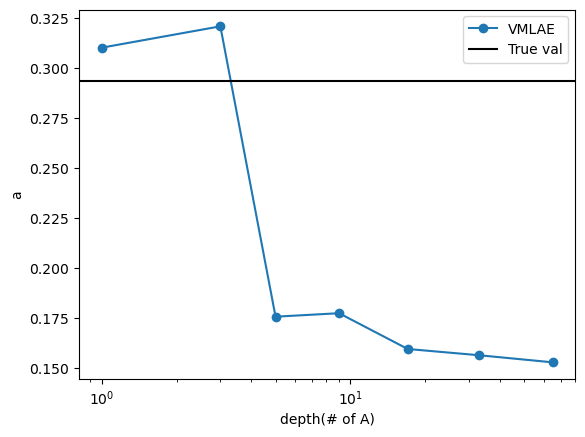

In [25]:
theta_Candidates = cal_theta(n_grovers, hits, shots=shots)
plt.plot(2*np.array(n_grovers)+1, np.sin(theta_Candidates)**2, '-o', label = 'VMLAE')
plt.axhline(analytic_result, c='k', label = 'True val')
plt.legend()
plt.xscale('log')
plt.ylabel('a')
plt.xlabel('depth(# of A)')

Text(0.5, 0, 'depth(# of A)')

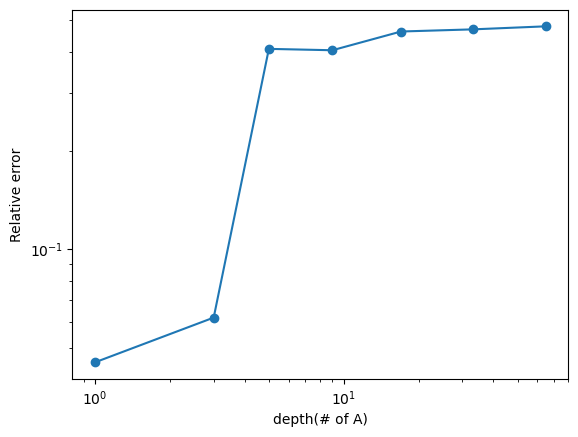

In [11]:
plt.plot(2*np.array(n_grovers)+1, np.abs(np.sin(theta_Candidates)**2-analytic_result)/analytic_result, '-o')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Relative error')
plt.xlabel('depth(# of A)')

## Conclusion
The VQAE system needs to more suitable ansatz for given function.
Also it will need more study to work on multiple qubits to successfully run this system.